### Task Description
Dataset Preparation: Utilize the dataset available at Amazon Product Data. For the purpose of this task, extract a subset of 200,000 records in total to be divided into training, validation, and testing sets.
Model Implementation: Apply the RoBERTa model for sentiment analysis on the prepared dataset. Focus on preprocessing the data effectively for the model, training the model, and plotting both training and validation curves to monitor performance over time.
Evaluation: Assess the model's performance on the test set. Present key metrics that highlight the accuracy and effectiveness of your sentiment analysis.
### Todo List
- [✅] 1. Load the dataset and extract a subset of 200,000 records.---》choose 278677 data records and then randomly choose 200000 records.
- [✅] 2. split the dataset into training, validation, and testing sets and putt in dataset
- [✅] 3. train a roberta model and save it properly
- [✅] 4. plot the training and validation curves
- [✅] 5. evaluate the model on the test set

Task Analysis
For this task, the most difficult thing is not on the training of the model, but how to handle the data.
Because here we have 200,000 data records, so we need to handle the data properly to integrate the code. So I prepared two different data - one is debug_data with 1000 train,val, and test data records, and the other is the whole data records.
For the debug_data_set, I can quickly iterate the code to find the different tricks for model improvement.
For the whole data record, I can train the model and evaluate the model on the test set.
One mistake is that the whole epoch training is not good for the log system, after trying to train the model for 3 epochs, I find that the model is good enough.
So for future intergration, I put it to the test not only in the epoch but also in the different interactions.
For the model improvement, I am training to use conserve learning to improve the model performance. But the result is not good. So I will try to use the different learning rates to improve the model's performance.


Note:All of code is running at gtx 4060 x2

In [32]:
import json
from tqdm import tqdm

file_path = 'Clothing_Shoes_and_Jewelry_5.json'
data_list = []
data = {}
with open(file_path, 'r', encoding='utf-8') as file:
    for line in tqdm(file):
        data = json.loads(line)
        data_list.append(data)


278677it [00:00, 278974.05it/s]


In [33]:
print('Total number of reviews:', len(data_list))
print('First review:', data_list[0])

Total number of reviews: 278677
First review: {'reviewerID': 'A1KLRMWW2FWPL4', 'asin': '0000031887', 'reviewerName': 'Amazon Customer "cameramom"', 'helpful': [0, 0], 'reviewText': "This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++", 'overall': 5.0, 'summary': 'Great tutu-  not cheaply made', 'unixReviewTime': 1297468800, 'reviewTime': '02 12, 2011'}


In [34]:
#sample data_list with 200,000 with random seed 42
import random
random.seed(42)
random.shuffle(data_list)
data_list = data_list[:200000]

In [4]:
#clean data to {text：, label: positive/negative}
def clean_data(data_list):
    cleaned_data = []
    for data in data_list:
        if data['overall'] > 3:
            label = 'positive'
        else:
            label = 'negative'
        cleaned_data.append({'text': data['reviewText'], 'label': label})
    return cleaned_data
clean_data_list = clean_data(data_list)

In [6]:
#write cleaned data to file
#split  training, validation, and testing sets.
from sklearn.model_selection import train_test_split
import os
train_data, test_data = train_test_split(clean_data_list, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
data_path = './data/'
file_name = 'Clothing_Shoes_and_Jewelry'
with open(os.path.join(data_path, file_name + '_train.json'), 'w', encoding='utf-8') as file:
    file.write(json.dumps(train_data))
with open(os.path.join(data_path, file_name + '_val.json'), 'w', encoding='utf-8') as file:
    file.write(json.dumps(val_data))
with open(os.path.join(data_path, file_name + '_test.json'), 'w', encoding='utf-8') as file:
    file.write(json.dumps(test_data))


['> creating model roberta', '> cuda memory allocated: 499891712', '> training arguments:', '>>> data_dir: data', '>>> dataset: amazon-jewel-debug', '>>> model_name: roberta', '>>> method: ce', '>>> train_batch_size: 16', '>>> test_batch_size: 64', '>>> num_epoch: 100']


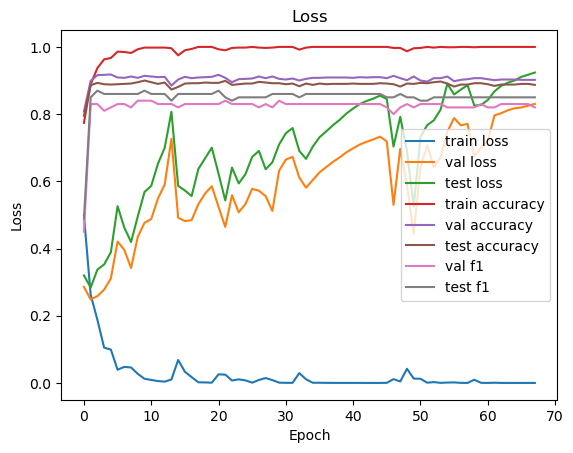

In [13]:
#plot the training, validation, and testing loss,accuracy
import matplotlib.pyplot as plt
import numpy as np

log_path = './logs/amazon-jewel-debug_roberta_ce_24-03-25_12-32-06.log'
with open(log_path, 'r', encoding='utf-8') as file:
    log = file.read().split('\n')
print(log[:10])
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
val_f1 = []
test_loss = []
test_accuracy = []
test_f1 = []
#[train] loss: 1.0979, acc: 99.80
#[test] loss: 3.5337, acc: 88.50, f1: 0.83
#[val] loss: 3.5768, acc: 88.30, f1: 0.83
for line in log:
    if '[train]' in line:
        train_loss.append(float(line.split('loss: ')[1].split(',')[0]))
        train_accuracy.append(float(line.split('acc: ')[1])/100)
    elif '[val]' in line:
        val_loss.append(float(line.split('loss: ')[1].split(',')[0]))
        val_accuracy.append(float(line.split('acc: ')[1].split(',')[0])/100)
        val_f1.append(float(line.split('f1: ')[1]))
    elif '[test]' in line:
        test_loss.append(float(line.split('loss: ')[1].split(',')[0]))
        test_accuracy.append(float(line.split('acc: ')[1].split(',')[0])/100)
        test_f1.append(float(line.split('f1: ')[1]))
#plot loss,acc,f1
plt.figure()
plt.plot(np.arange(len(train_loss)), train_loss, label='train loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val loss')
plt.plot(np.arange(len(test_loss)), test_loss, label='test loss')
plt.plot(np.arange(len(train_accuracy)), train_accuracy, label='train accuracy')
plt.plot(np.arange(len(val_accuracy)), val_accuracy, label='val accuracy')
plt.plot(np.arange(len(test_accuracy)), test_accuracy, label='test accuracy')
plt.plot(np.arange(len(val_f1)), val_f1, label='val f1')
plt.plot(np.arange(len(test_f1)), test_f1, label='test f1')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

['> creating model roberta', '> cuda memory allocated: 499891712', '> training arguments:', '>>> data_dir: data', '>>> dataset: amazon-jewel-debug', '>>> model_name: roberta', '>>> method: dualcl', '>>> train_batch_size: 16', '>>> test_batch_size: 64', '>>> num_epoch: 100']


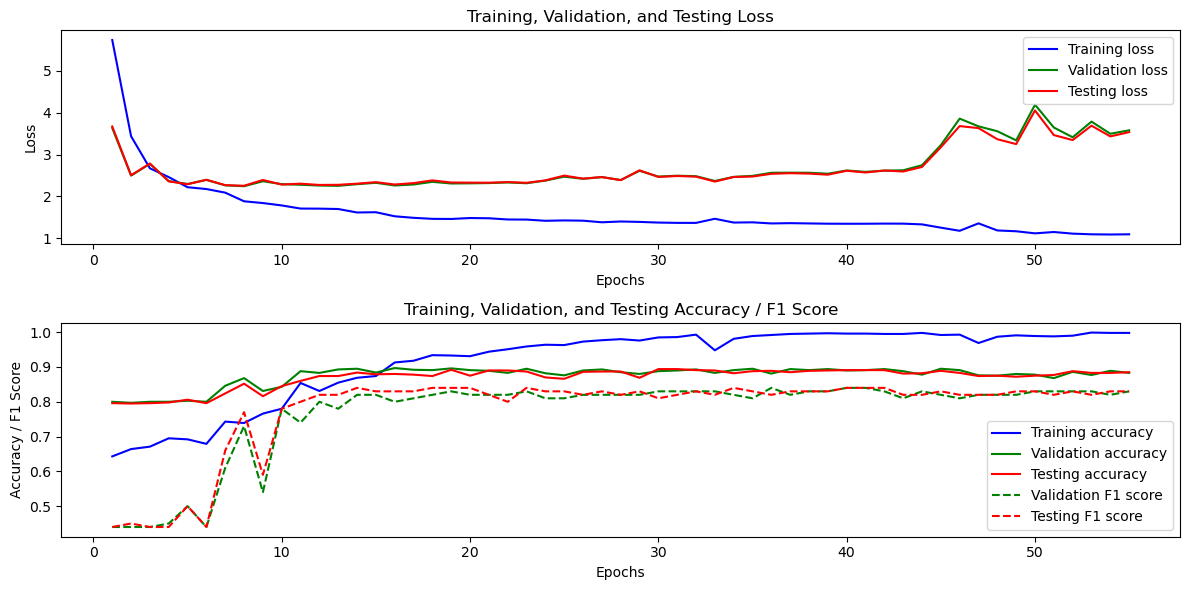

In [15]:
#plot the training, validation, and testing loss,accuracy
import matplotlib.pyplot as plt
import numpy as np

log_path = './logs/amazon-jewel-debug_roberta_dualcl_24-03-25_12-37-07.log'
with open(log_path, 'r', encoding='utf-8') as file:
    log = file.read().split('\n')
print(log[:10])
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
val_f1 = []
test_loss = []
test_accuracy = []
test_f1 = []
#[train] loss: 1.0979, acc: 99.80
#[test] loss: 3.5337, acc: 88.50, f1: 0.83
#[val] loss: 3.5768, acc: 88.30, f1: 0.83
for line in log:
    if '[train]' in line:
        train_loss.append(float(line.split('loss: ')[1].split(',')[0]))
        train_accuracy.append(float(line.split('acc: ')[1])/100)
    elif '[val]' in line:
        val_loss.append(float(line.split('loss: ')[1].split(',')[0]))
        val_accuracy.append(float(line.split('acc: ')[1].split(',')[0])/100)
        val_f1.append(float(line.split('f1: ')[1]))
    elif '[test]' in line:
        test_loss.append(float(line.split('loss: ')[1].split(',')[0]))
        test_accuracy.append(float(line.split('acc: ')[1].split(',')[0])/100)
        test_f1.append(float(line.split('f1: ')[1]))
#plot loss,acc,f1
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(epochs, test_loss, 'r', label='Testing loss')
plt.title('Training, Validation, and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.plot(epochs, test_accuracy, 'r', label='Testing accuracy')
plt.plot(epochs, val_f1, 'g--', label='Validation F1 score')
plt.plot(epochs, test_f1, 'r--', label='Testing F1 score')
plt.title('Training, Validation, and Testing Accuracy / F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

from the plot we can get conclusion by this
1. for two classification problem, it is so easy to overfit and achieve a ok result-acc 0.9
2. in small dataset, use constral learning can make the loss more steady

then because we have enough code,we can think about even make this question as 5-classification problem.

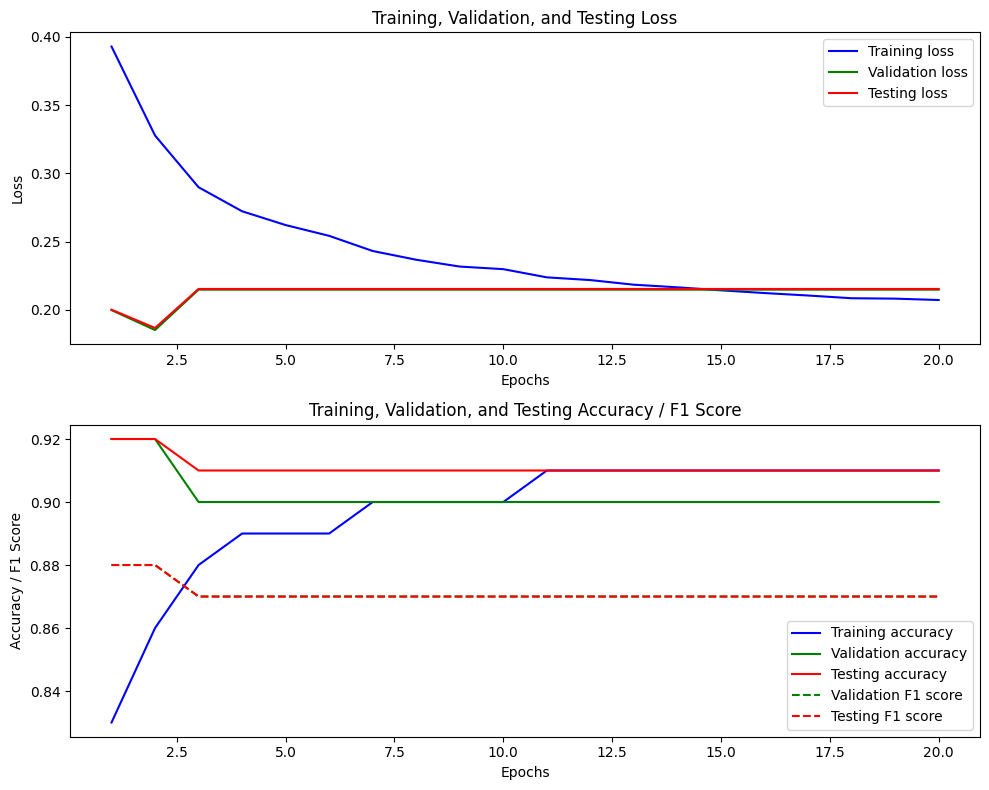

In [4]:
import numpy as np
import matplotlib.pyplot as plt

log_path = './logs/amazon-jewel_roberta_ce_24-03-25_20-52-09.log'
with open(log_path, 'r', encoding='utf-8') as file:
    log = file.read().split('\n')

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
val_f1 = []
test_loss = []
test_accuracy = []
test_f1 = []

for line in log:
    if '[train]' in line:
        train_loss.append(float(line.split('loss: ')[1].split(',')[0]))
        train_accuracy.append(float(line.split('acc: ')[1]))
    elif '[val]' in line:
        val_loss.append(float(line.split('loss: ')[1].split(',')[0]))
        val_accuracy.append(float(line.split('acc: ')[1].split(' ')[0]))
        val_f1.append(float(line.split('f1: ')[1].split(' ')[0]))
    elif '[test]' in line:
        test_loss.append(float(line.split('loss: ')[1].split(',')[0]))
        test_accuracy.append(float(line.split('acc: ')[1].split(' ')[0]))
        test_f1.append(float(line.split('f1: ')[1].split(' ')[0]))

# Interpolate to match lengths of val and test data with train data
if len(val_loss) < len(train_loss):
    val_loss = np.interp(range(len(train_loss)), np.linspace(0, len(val_loss) - 1, len(val_loss)), val_loss)
    val_accuracy = np.interp(range(len(train_loss)), np.linspace(0, len(val_accuracy) - 1, len(val_accuracy)), val_accuracy)
    val_f1 = np.interp(range(len(train_loss)), np.linspace(0, len(val_f1) - 1, len(val_f1)), val_f1)

if len(test_loss) < len(train_loss):
    test_loss = np.interp(range(len(train_loss)), np.linspace(0, len(test_loss) - 1, len(test_loss)), test_loss)
    test_accuracy = np.interp(range(len(train_loss)), np.linspace(0, len(test_accuracy) - 1, len(test_accuracy)), test_accuracy)
    test_f1 = np.interp(range(len(train_loss)), np.linspace(0, len(test_f1) - 1, len(test_f1)), test_f1)

epochs_train = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs_train, train_loss, 'b', label='Training loss')
plt.plot(epochs_train, val_loss, 'g', label='Validation loss')
plt.plot(epochs_train, test_loss, 'r', label='Testing loss')
plt.title('Training, Validation, and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_train, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs_train, val_accuracy, 'g', label='Validation accuracy')
plt.plot(epochs_train, test_accuracy, 'r', label='Testing accuracy')
plt.plot(epochs_train, val_f1, 'g--', label='Validation F1 score')
plt.plot(epochs_train, test_f1, 'r--', label='Testing F1 score')
plt.title('Training, Validation, and Testing Accuracy / F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
#ERROR ANALYSIS
import torch
from tqdm import tqdm
from sklearn.metrics import f1_score
from transformers import logging, AutoTokenizer, AutoModel
from model import Transformer
from data_utils import load_data
tokenizer = AutoTokenizer.from_pretrained('roberta-base', add_prefix_space=True)
base_model = AutoModel.from_pretrained('roberta-base')
num_classes = 2
method = 'ce'
model = Transformer(base_model, num_classes,method)
model.load_state_dict(torch.load('./amazon-jewel_ce_best_model.pth'))
model.eval()
train_dataloader, val_dataloader, test_dataloader = load_data(dataset='amazon-jewel',
                                                              data_dir='data',
                                                              tokenizer=tokenizer,
                                                              train_batch_size=16,
                                                              test_batch_size=32,
                                                              model_name='roberta',
                                                              method='dualcl',
                                                              workers=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
pred_list = []
lable_list = []
input_list = []
pred_list = []
label_list = []

for inputs, targets in tqdm(test_dataloader, ascii=' >='):
    inputs = {k: v.to(device) for k, v in inputs.items()}
    targets = targets.to(device)
    outputs = model(inputs)
    pred = torch.argmax(outputs['predicts'], -1)
    #clean gpu memory
    torch.cuda.empty_cache()
    pred_list.extend(pred.cpu().numpy())  # Corrected line
    label_list.extend(targets.cpu().numpy())  # Corrected line


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|==========| 1742/1742 [07:26<00:00,  3.90it/s]


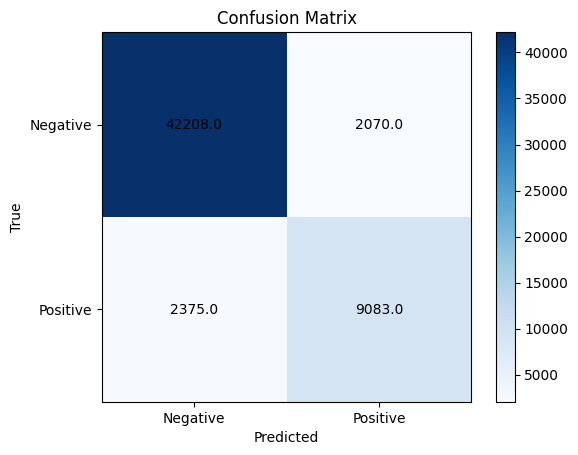

In [5]:
import numpy as np
# Get the predicted labels and confusion matrix
preds = np.array(pred_list)
labels = np.array(label_list)
confusion_matrix = np.zeros((2, 2))

for i in range(len(preds)):
    confusion_matrix[labels[i]][preds[i]] += 1

# Plot the confusion matrix
plt.figure()
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')

plt.show()


In [ ]:
#then we can try to do five class classification
def clean_data(data_list):
    cleaned_data = []
    for data in data_list:
        if data['overall'] == 1:
            label = 'very negative'
        elif data['overall'] == 2:
            label = 'negative'
        elif data['overall'] == 3:
            label = 'neutral'
        elif data['overall'] == 4:
            label = 'positive'
        else:
            label = 'very positive'
        cleaned_data.append({'text': data['reviewText'], 'label': label})
    return cleaned_data
clean_data_list = clean_data(data_list)
#write cleaned data to file
#split  training, validation, and testing sets.
from sklearn.model_selection import train_test_split
import os
train_data, test_data = train_test_split(clean_data_list, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_data = train_data[:20000]
val_data = val_data[:5000]
test_data = test_data[:5000]
data_path = './data/'
file_name = "amazon-jewel-five-debug"
with open(os.path.join(data_path, file_name + '_train.json'), 'w', encoding='utf-8') as file:
    file.write(json.dumps(train_data))
with open(os.path.join(data_path, file_name + '_val.json'), 'w', encoding='utf-8') as file:
    file.write(json.dumps(val_data))
with open(os.path.join(data_path, file_name + '_test.json'), 'w', encoding='utf-8') as file:
    file.write(json.dumps(test_data))

In [9]:
#ERROR ANALYSIS
import torch
from tqdm import tqdm
from sklearn.metrics import f1_score
from transformers import logging, AutoTokenizer, AutoModel
from model import Transformer
from data_utils import load_data
tokenizer = AutoTokenizer.from_pretrained('roberta-base', add_prefix_space=True)
base_model = AutoModel.from_pretrained('roberta-base')
num_classes = 5
method = 'ce'
model = Transformer(base_model, num_classes,method)
model.load_state_dict(torch.load('./amazon-jewel-5-debug_cebest_model.pth'))
model.eval()
train_dataloader, val_dataloader, test_dataloader = load_data(dataset='amazon-jewel-5-debug',
                                                              data_dir='data',
                                                              tokenizer=tokenizer,
                                                              train_batch_size=16,
                                                              test_batch_size=32,
                                                              model_name='roberta',
                                                              method='dualcl',
                                                              workers=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
pred_list = []
lable_list = []
input_list = []
pred_list = []
label_list = []

for inputs, targets in tqdm(test_dataloader, ascii=' >='):
    input_list.append(tokenizer.decode(inputs['input_ids'][0]))
    inputs = {k: v.to(device) for k, v in inputs.items()}
    targets = targets.to(device)
    outputs = model(inputs)

    pred = torch.argmax(outputs['predicts'], -1)
    #clean gpu memory
    torch.cuda.empty_cache()
    pred_list.extend(pred.cpu().numpy())  # Corrected line
    label_list.extend(targets.cpu().numpy())  # Corrected line



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|==========| 157/157 [00:40<00:00,  3.83it/s]


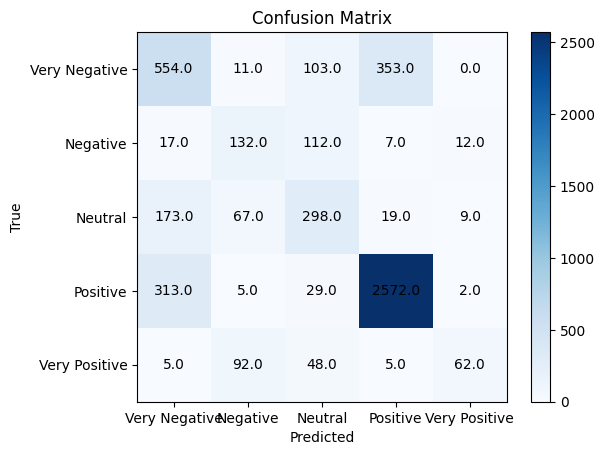

In [10]:
import numpy as np
# Get the predicted labels and confusion matrix
preds = np.array(pred_list)
labels = np.array(label_list)
confusion_matrix = np.zeros((5, 5))

for i in range(len(preds)):
    confusion_matrix[labels[i]][preds[i]] += 1

# Plot the confusion matrix
plt.figure()
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()
#{'positive': 0, 'negative': 1, 'neutral': 2, 'very positive': 3, 'very negative': 4}
plt.xticks([0, 1,2,3,4], ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
plt.yticks([0, 1,2,3,4], ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

for i in range(5):
    for j in range(5):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')

plt.show()


In [11]:
#see some error examples
error_list = []
for i in range(len(preds)):
    if preds[i] != labels[i]:
        error_list.append(i)
print('Total number of errors:', len(error_list))
for i in range(5):
    print('Error example', i)
    print('Predicted:', preds[error_list[i]])
    print('True:', labels[error_list[i]])
    print('Input:', input_list[error_list[i]])

Total number of errors: 1382
Error example 0
Predicted: 3
True: 0
Input: <s> positive negative neutral very positive very negative</s> i am going to keep this or give as a gift. i love stars on things. very nice blend of colors not bright, nice weight on the thinner side to wrap twice around your neck and not feel bulky.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [ ]:
#from the confusion matrix and error examples, we can see that the model has some difficulty in distinguishing between netural.
#there are some bias even people is hard to distinguish between neutral and positive/negative.
#some sentence is very long, witch is hard for roberta to understand.
#My conclusion:
#1. the model is good at distinguishing between positive and negative reviews, but it is not good at distinguishing between neutral and positive/negative reviews.
#2. the model is not good at long sentence, which is hard for roberta to understand.
#3. for the roberta model, low number of train data still can perform well.